In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e1/sample_submission.csv
/kaggle/input/playground-series-s4e1/train.csv
/kaggle/input/playground-series-s4e1/test.csv


In [2]:
TRAINCSV = '/kaggle/input/playground-series-s4e1/train.csv'
TESTCSV = '/kaggle/input/playground-series-s4e1/test.csv'
RANDOM = 7

In [3]:
# import block
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score
from sklearn.model_selection import KFold, train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
import matplotlib.pyplot as plt
from scipy import stats

import seaborn as sns

## Data reading in

In [4]:
df = pd.read_csv(TRAINCSV)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               165034 non-null  int64  
 1   CustomerId       165034 non-null  int64  
 2   Surname          165034 non-null  object 
 3   CreditScore      165034 non-null  int64  
 4   Geography        165034 non-null  object 
 5   Gender           165034 non-null  object 
 6   Age              165034 non-null  float64
 7   Tenure           165034 non-null  int64  
 8   Balance          165034 non-null  float64
 9   NumOfProducts    165034 non-null  int64  
 10  HasCrCard        165034 non-null  float64
 11  IsActiveMember   165034 non-null  float64
 12  EstimatedSalary  165034 non-null  float64
 13  Exited           165034 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 17.6+ MB


In [6]:
df.describe()

,id,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,165034.0000,1.650340e+05,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000
mean,82516.5000,1.569201e+07,656.454373,38.125888,5.020353,55478.086689,1.554455,0.753954,0.497770,112574.822734,0.211599
std,47641.3565,7.139782e+04,80.103340,8.867205,2.806159,62817.663278,0.547154,0.430707,0.499997,50292.865585,0.408443
min,0.0000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,41258.2500,1.563314e+07,597.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,74637.570000,0.000000
50%,82516.5000,1.569017e+07,659.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,117948.000000,0.000000
75%,123774.7500,1.575682e+07,710.000000,42.000000,7.000000,119939.517500,2.000000,1.000000,1.000000,155152.467500,0.000000
max,165033.0000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


In [7]:
df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


## Data wrangling

In [8]:
# checking nan
df.isna().sum()

id                 0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [9]:
print(f'unique customer id {df.CustomerId.nunique()}')
print(f'unique id {df.id.nunique()}')

unique customer id 23221
unique id 165034


In [10]:
df.duplicated(subset=['CustomerId'])

0         False
1         False
2         False
3         False
4         False
          ...  
165029     True
165030     True
165031     True
165032     True
165033     True
Length: 165034, dtype: bool

In [11]:
# see what's duplicated row like
# df['CustomerId'][0]
# df[df['id']==165029]
df[df['CustomerId']==15667085]

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
8375,8375,15667085,Meng,679,France,Male,33.0,1,0.00,2,1.0,0.0,131834.75,0
11187,11187,15667085,Lucchesi,769,France,Male,26.0,7,0.00,2,1.0,0.0,176843.53,0
11580,11580,15667085,Trevisano,594,France,Male,48.0,7,0.00,2,1.0,1.0,150694.76,0
14511,14511,15667085,Wei,790,France,Female,37.0,3,151290.16,1,0.0,1.0,172497.73,1
25011,25011,15667085,Ch'en,753,France,Female,33.0,5,0.00,2,1.0,1.0,28797.64,0
25887,25887,15667085,Padovesi,675,France,Female,34.0,3,0.00,2,1.0,1.0,141180.66,0
26708,26708,15667085,Lo Duca,733,Spain,Male,35.0,5,0.00,2,1.0,0.0,106977.80,0
34432,34432,15667085,Tuan,646,France,Male,50.0,3,0.00,2,0.0,1.0,163810.34,0
37407,37407,15667085,Ch'in,579,Germany,Male,47.0,4,132767.66,1,1.0,0.0,180932.46,1
39266,39266,15667085,Meng,667,France,Male,33.0,4,160566.11,1,0.0,1.0,142903.44,1


This is a synthetic dataset, so that it seems like `CustomerId` here doesn't make much sense.

## clean data anyway

In [12]:
df.dropna(inplace=True)
df.drop(columns=['id', 'CustomerId', 'Surname'], inplace=True, errors='ignore')

In [13]:
numerical_cols = list(set(df.columns)-{'Geography', 'Gender', 'id', 'CustomerId', 'Surname', 'Exited'})

In [14]:
print(df.size)
# Get rid of outlier using zscore
df = df[(np.abs(stats.zscore(df[numerical_cols])) < 3).all(axis=1)]
print(df.size)

1815374
1786939


In [15]:
df.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,162449.000000,162449.000000,162449.000000,162449.000000,162449.000000,162449.000000,162449.000000,162449.000000,162449.000000
mean,656.633571,37.727507,5.019674,55414.313813,1.547347,0.754274,0.494438,112634.117011,0.209721
std,79.694881,8.198040,2.805242,62799.676537,0.531753,0.430518,0.499971,50273.632414,0.407111
min,417.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,597.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,74835.650000,0.000000
50%,659.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,118030.060000,0.000000
75%,710.000000,42.000000,7.000000,119859.520000,2.000000,1.000000,1.000000,155155.250000,0.000000
max,850.000000,64.000000,10.000000,238387.560000,3.000000,1.000000,1.000000,199992.480000,1.000000


## EDA

In [16]:
label_encoder = LabelEncoder()

categoricals = ['Geography', 'Gender']
for col in categoricals:
    df[col] = label_encoder.fit_transform(df[col])

<Axes: >

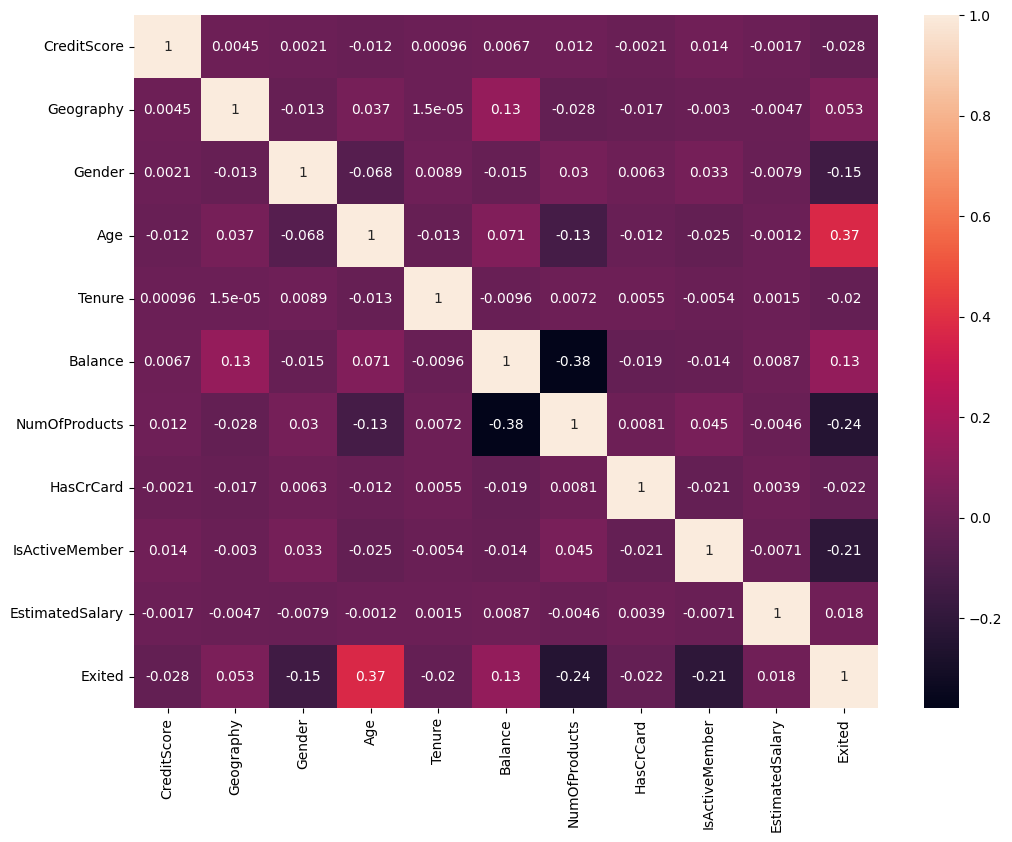

In [17]:
plt.figure(figsize=(12, 9))
sns.heatmap(data = df.corr(), annot=True)

`Age`,`Balance`, `Geography` and `EstimatedSalary` have correlations with `Exited`

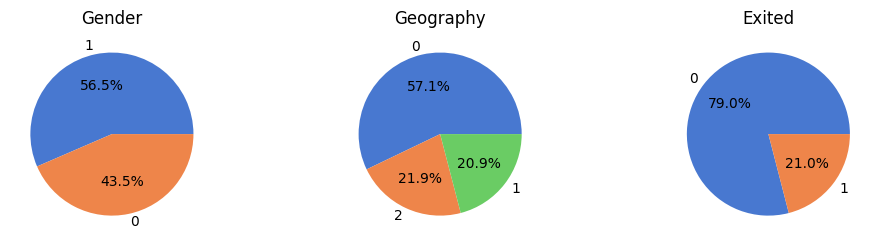

In [18]:
plt.figure(figsize=(12,9))
for i, col in enumerate(['Gender', 'Geography', 'Exited']):
    plt.subplot(3,3,i+1)
    x = df[col].value_counts().reset_index()
    plt.title(col)
    plt.pie(x=x['count'], labels = x[col], autopct="%0.1f%%",colors=sns.color_palette('muted'))

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

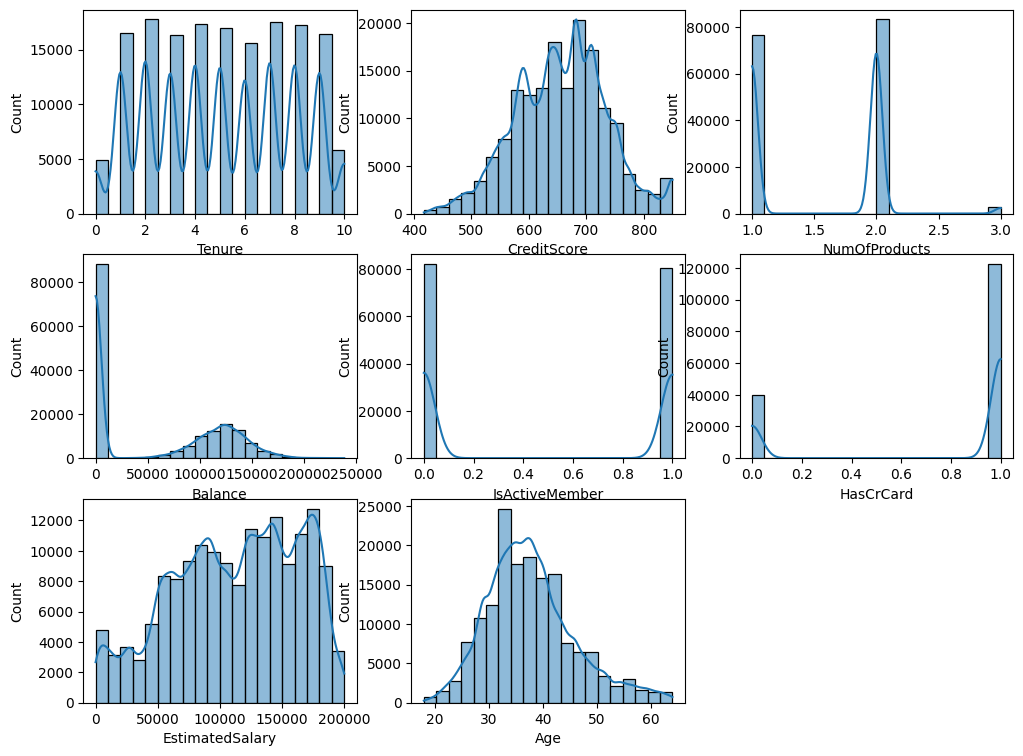

In [19]:
# hist plot of each numericals
plt.figure(figsize=(12, 9))
for i, col in enumerate(numerical_cols):
    plt.subplot(3,3, i+1)
    sns.histplot(data=df, x=col, bins=20, kde=True)

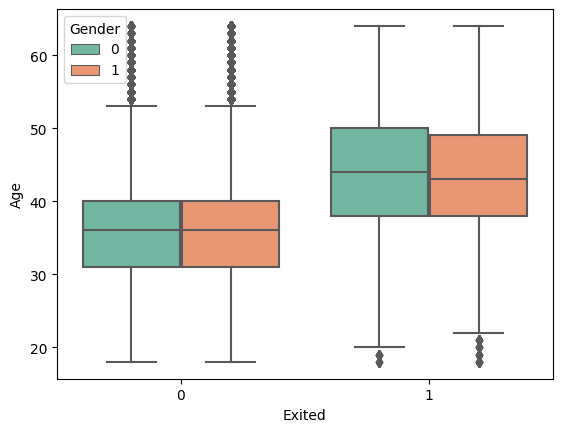

In [20]:
sns.boxplot(data=df, x=df.Exited, y=df.Age, hue='Gender', palette=sns.color_palette(palette='Set2'))
plt.show()

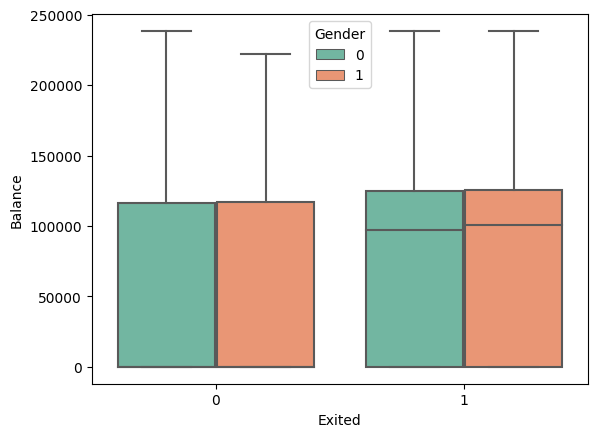

In [21]:
sns.boxplot(data=df, x=df.Exited, y=df.Balance, hue='Gender', palette=sns.color_palette(palette='Set2'))
plt.show()

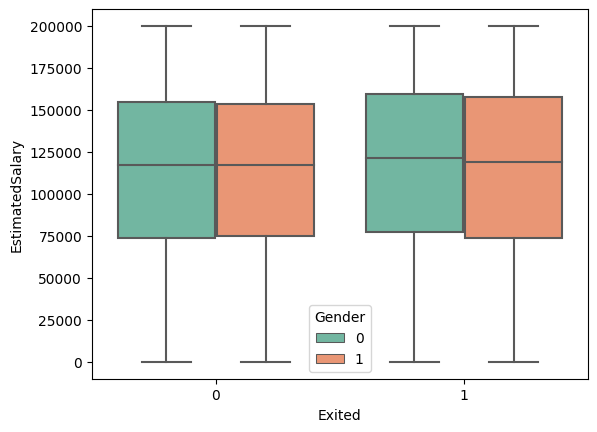

In [22]:
sns.boxplot(data=df, x=df.Exited, y=df.EstimatedSalary, hue='Gender', palette=sns.color_palette(palette='Set2'))
plt.show()

/tmp/ipykernel_18/413918227.py:1: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.scatterplot(data=df, x=df.Age, y=df.Balance, hue='Exited', palette=sns.color_palette(palette='dark'))
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


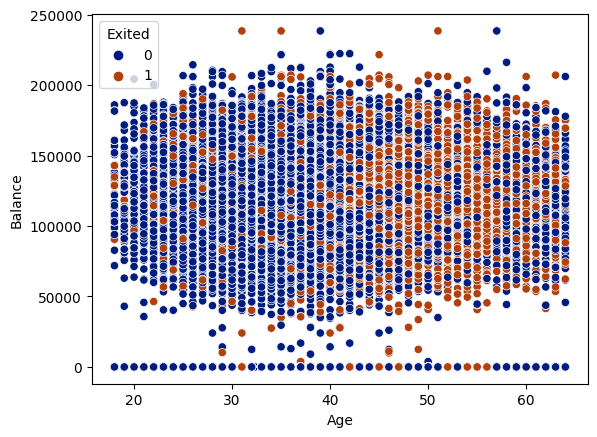

In [23]:
sns.scatterplot(data=df, x=df.Age, y=df.Balance, hue='Exited', palette=sns.color_palette(palette='dark'))
plt.show()

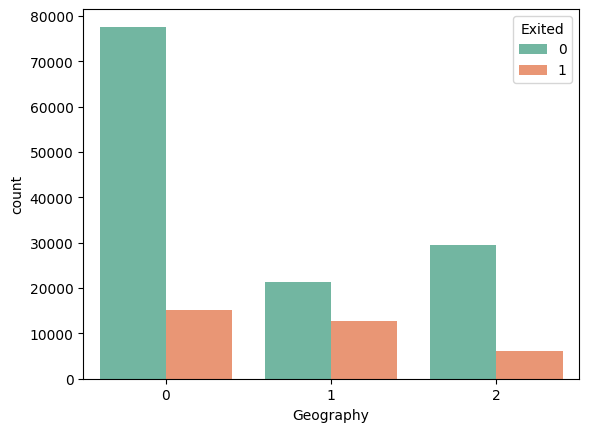

In [24]:
sns.countplot(data=df, x=df.Geography, hue='Exited', palette=sns.color_palette(palette='Set2'))
plt.show()

## Upsampling `Exited`

In [25]:
exited=df[df['Exited']==1]
noexited=df[df['Exited']==0]

upsample_exited=resample(exited, replace=True, n_samples=noexited.shape[0])
ndf = pd.concat([upsample_exited, noexited])

ndf['Exited'].value_counts()

Exited
1    128380
0    128380
Name: count, dtype: int64

## Train

In [26]:
X, y = ndf.loc[:, ndf.columns!='Exited'], ndf.loc[:, ndf.columns=='Exited']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=RANDOM)

In [27]:
fixed_params = {
    "subsample": 0.5,
    "min_samples_leaf": 1,
    "random_state": RANDOM
}
params = {
    "n_estimators": np.arange(50, 1200, 200),
    "max_depth": np.arange(2, 10),
    "learning_rate": np.linspace(0.01, 0.2, 10)
}

# Initialize the Gradient Boosting model
clf = GradientBoostingClassifier(**fixed_params)
 
# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=clf, param_distributions=params, n_iter=10,
                                   cv=5, scoring='roc_auc', random_state=RANDOM, n_jobs=-1)
 
# Fit the model to the training data using RandomizedSearchCV
random_search.fit(X_train, y_train)
 
# Get the best parameters and best model
best_params_random = random_search.best_params_
best_model_random = random_search.best_estimator_
 
# Make predictions on the test set using the best model
y_pred_best_random = best_model_random.predict(X_test)
 
# Evaluate the best model
auc_best_random = roc_auc_score(y_test, y_pred_best_random)
 
# Print the results
print("Best Parameters (Randomized Search):", best_params_random)
print(f"Best Model AUC (Randomized Search): {auc_best_random}")

/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 

Best Parameters (Randomized Search): {'n_estimators': 650, 'max_depth': 9, 'learning_rate': 0.1788888888888889}
Best Model AUC (Randomized Search): 0.9058127988086817


In [28]:
# test
df_test = pd.read_csv(TESTCSV)
# df_test
df_test_ids = df_test['id']

df_test.drop(['CustomerId', 'Surname', 'id'], axis=1, errors='ignore', inplace=True)

for col in categoricals:
    df_test[col] = label_encoder.fit_transform(df_test[col])

y_pred = best_model_random.predict_proba(df_test)


In [29]:
OUTPUT = '/kaggle/working/submission.csv'
df_out = pd.DataFrame({'id': df_test_ids, 'Exited': y_pred[:, 1]})
df_out.to_csv(f'{OUTPUT}', index=False)